# Final Project Submission

Please fill out:
* Student name: Joseph Husney
* Student pace: full time
* Scheduled project review date/time: 8/06/2020 5:00 pm
* Instructor name: James Irving
* Blog post URL: https://jhusney1.github.io/reasons_to_use_webscraping_over_apis

## Introduction
Microsoft is trying to break into the movie industry and they wanted some recommendations on how to get started. Their measure of success will be the profit earned domestically. Using the budget and domestic revenue for these movies, we will analyze a few different aspects of movies to measure the success rate. We will be using a DataFrame which comes from themoviedb.com and contains all movies from as early as 1960 and goes up until the present day. The reason for analyzing such a wide range of movies is because Microsoft wants to see the bigger picture of which movies are profitable over a long period of time. They feel that trends can change and it isn't worth it to invest in something specific that was profitable in the last five years and will most probably change soon enough.

## Retrieve Data

### Import necessary modules

In [78]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
from tqdm import tqdm

In [79]:
#Allowing pandas to display unlimited info
# pd.set_option('display.max_rows', 1000)
# pd.set_option('display.max_columns', 1000)

### Importing dataframe
Before analyzing the data, it must first be retrieved. The dataframe we will be importing is a collection of 5000 most popular movies ranging as early as 1960 until the present day. We will use this info to get all kinds of details which we can further analyze. We will put this into a pandas dataframe so we can utilize all the tools pandas has to offer.

In [80]:
# Load csv file to dataframe
df = pd.read_csv('zippedData/tmdb_5000_movies.csv')
# Preview data
print(df.head())
# See how long dataframe is
print(df.shape)

      budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3  250000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4  260000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...                en   
2  [{"id": 470, "nam

## Data Cleaning
Upon inspecting the data, it became clear that there are many movies missing certain important data points. For instance, some movies don't have genre data. Others have a budget and/or revenue of zero. Here we will clean up the data by deleting those rows from the dataframe.

### Get rid of rows without genre data

In [81]:
# See if there are any null values for genre
df.isna().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

In [82]:
# No null values - this code isn't necessary for now
# df = df[~df['genres'].isna()]

### Get rid of rows with budget or revenue of zero

In [83]:
# Find out how many rows we are dropping
indexNames1 = df[ df['budget'] == 0 ].index
indexNames2 = df[ df['revenue'] == 0 ].index
len(indexNames1), len(indexNames2)

(1037, 1427)

In [84]:
# Drop rows
indexNames = df[ df['budget'] == 0 ].index
df.drop(indexNames , inplace=True)


indexNames = df[ df['revenue'] == 0 ].index
df.drop(indexNames , inplace=True)

# See shape after dropping all those rows
df.shape

(3229, 20)

## Now we will discuss three questions that will shed some light on which movies Microsoft should invest in

### Question 1: What is the *domestic* average movie profit categorized by genre?

In [85]:
# Check type of genre column in order to manipulate data
type(df['genres'][0])

str

In [86]:
# Convert to list of dictionaries that it originally was.
import ast
df['genres'] = df['genres'].map(ast.literal_eval)

In [87]:
type(df['genres'][0])

list

In [88]:
def seperate_genres(genre_list):
    genres = []
    for genre in genre_list:
            genres.append(genre['name'])
    return genres

In [89]:
# Make separate column for genres as a list of genre names
df['genre'] = df['genres'].map(seperate_genres)
df['genre'].head()

0    [Action, Adventure, Fantasy, Science Fiction]
1                     [Adventure, Fantasy, Action]
2                       [Action, Adventure, Crime]
3                 [Action, Crime, Drama, Thriller]
4             [Action, Adventure, Science Fiction]
Name: genre, dtype: object

In [90]:
# Let's get all the genres in its own row using the explode function. It will duplicate all
# the other parts of each row and make a new row for each separate genre 
genre_df = df.explode('genre')

# Create profit column to evenutually use as a meausre of success for these movies
genre_df['profit'] = genre_df['revenue'] - genre_df['budget']

# Preview Data
genre_df[['title','budget','revenue', 'profit']].head()

,title,budget,revenue,profit
0,Avatar,237000000,2787965087,2550965087
0,Avatar,237000000,2787965087,2550965087
0,Avatar,237000000,2787965087,2550965087
0,Avatar,237000000,2787965087,2550965087
1,Pirates of the Caribbean: At World's End,300000000,961000000,661000000


In [91]:
# Create Order based on profit so plotting will be in order
genre_order = list(genre_df.groupby('genre')['profit'].mean().sort_values(ascending=False).index)
genre_order

['Animation',
 'Adventure',
 'Fantasy',
 'Family',
 'Science Fiction',
 'Action',
 'Comedy',
 'Thriller',
 'Romance',
 'Mystery',
 'War',
 'Music',
 'Crime',
 'Drama',
 'Horror',
 'History',
 'Western',
 'Documentary',
 'Foreign']

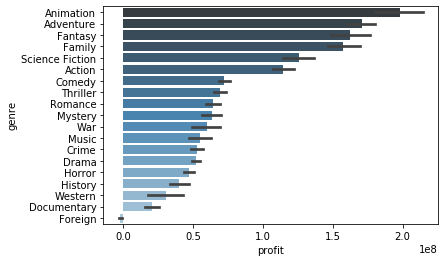

In [92]:
sns.barplot(y= 'genre', x='profit', data=genre_df, ci=68,order=genre_order, palette="Blues_d")

#### Conclusion: The 5 most profitable genres are Animation, Adventure, Fantasy, Family, and Science Fiction. We recommend that microsoft invest in animated movies.

### Question 2: Is there an optimal runtime (in terms of profit) for movies domestically. If so, what is it? 

In [93]:
# Duplicate original dataframe and add profit column as before
df_runtime = df.copy()
df_runtime['profit'] = df_runtime['revenue'] - df_runtime['budget']
df_runtime['runtime'].head()

0    162.0
1    169.0
2    148.0
3    165.0
4    132.0
Name: runtime, dtype: float64

In [94]:
# slice out 50 most profitable movies to analyze
df_runtime = df_runtime.sort_values('profit',ascending=False).head(50)

# Preview relevant columns
df_runtime[['title', 'profit', 'runtime']].head(10)

,title,profit,runtime
0,Avatar,2550965087,162.0
25,Titanic,1645034188,194.0
28,Jurassic World,1363528810,124.0
44,Furious 7,1316249360,137.0
16,The Avengers,1299557910,143.0
7,Avengers: Age of Ultron,1125403694,141.0
124,Frozen,1124219009,102.0
546,Minions,1082730962,91.0
329,The Lord of the Rings: The Return of the King,1024888979,201.0
31,Iron Man 3,1015439994,130.0


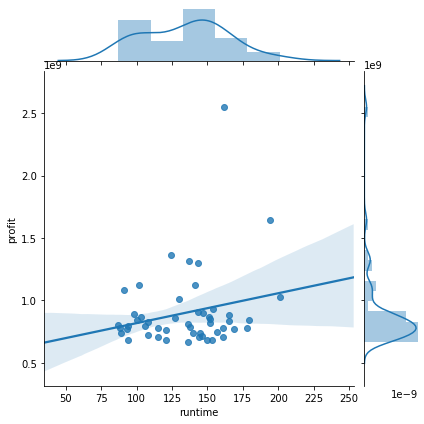

In [95]:
sns.jointplot("runtime", "profit", data=df_runtime, kind="reg")

#### Conclusion: As illustrated in this plot, there is a small  positive correlation between lengthy movies and how profitable they are. One thing to take note of is that out of the 50 most profitable movies, a big portion of them were around 100 minutes long or around 125-150 minutes long (as illustrated by the bars above the plot). Clearly, they are doing something right. Therefore, microsoft should make movies that are between 125 and 150 minutes long to mimic the most profitable movies.

### Question 3: Which production company(s) are most successful in terms of domestic profit and therefore should be used?

In [96]:
# Ensure that our original dataset is unchanged
print(df.shape)
df.head()

(3229, 21)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,genre
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[Action, Adventure, Fantasy, Science Fiction]"
1,300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[Adventure, Fantasy, Action]"
2,245000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[Action, Adventure, Crime]"
3,250000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[Action, Crime, Drama, Thriller]"
4,260000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,"[Action, Adventure, Science Fiction]"


### Inspect production company column (type, etc)

In [97]:
type(df['production_companies'][0][0])

str

In [98]:
# Convert to list of dicts from string using ast package as we did by genres
df['production_companies'] = df['production_companies'].map(ast.literal_eval)

# Inspect type (ie ensure that it worked)
print(type(df['production_companies'][0][0]))

# preview first movies production companies
list_of_dicts = df['production_companies'][0]
list_of_dicts

<class 'dict'>


[{'name': 'Ingenious Film Partners', 'id': 289},
 {'name': 'Twentieth Century Fox Film Corporation', 'id': 306},
 {'name': 'Dune Entertainment', 'id': 444},
 {'name': 'Lightstorm Entertainment', 'id': 574}]

In [99]:
# Create function to take names from the dictionary and append to a list 
def seperate_production_companies(company_list):
    company_names = []
    for dict_ in company_list:
        company_names.append(dict_['name'])
    return company_names

# Apply function
df['production_companies'] = df['production_companies'].map(seperate_production_companies)
df['production_companies'].head()

0    [Ingenious Film Partners, Twentieth Century Fo...
1    [Walt Disney Pictures, Jerry Bruckheimer Films...
2                     [Columbia Pictures, Danjaq, B24]
3    [Legendary Pictures, Warner Bros., DC Entertai...
4                               [Walt Disney Pictures]
Name: production_companies, dtype: object

In [100]:
# Separate rows for each individual company (as we did by genres) using explode function
production_company_df = df.explode('production_companies')
production_company_df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,genre
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,Ingenious Film Partners,...,2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[Action, Adventure, Fantasy, Science Fiction]"
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,Twentieth Century Fox Film Corporation,...,2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[Action, Adventure, Fantasy, Science Fiction]"
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,Dune Entertainment,...,2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[Action, Adventure, Fantasy, Science Fiction]"
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,Lightstorm Entertainment,...,2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[Action, Adventure, Fantasy, Science Fiction]"
1,300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,Walt Disney Pictures,...,2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[Adventure, Fantasy, Action]"


In [101]:

production_companies_sorted = production_company_df['production_companies'].value_counts()
production_companies_sorted.head()

Warner Bros.                              280
Universal Pictures                        273
Paramount Pictures                        245
Twentieth Century Fox Film Corporation    201
Columbia Pictures                         167
Name: production_companies, dtype: int64

In [102]:
# Filter to 50 most profitable movies
production_company_df = production_company_df[production_company_df.groupby('production_companies')['production_companies'].transform('count').ge(30)]

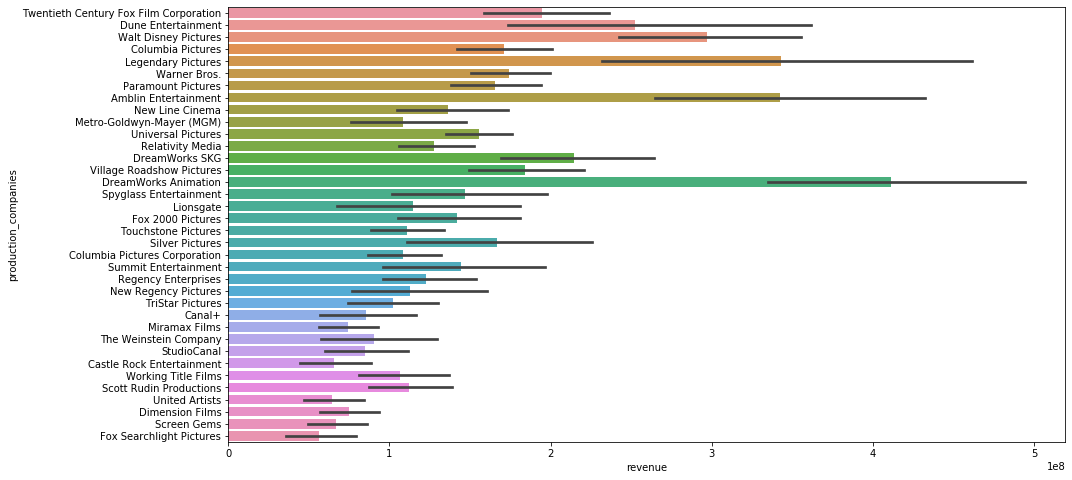

In [103]:
fig_dims = (15,8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x = "revenue", y = "production_companies", ax=ax, data=production_company_df)

#### Conclusion: The top production companies in terms of revenue are DreamWorks animation, Lengendary Pictures, Amblin Entertainment, Walt Disney Pictures, and Dune entertainment. Therefore, microsoft should consider consulting with these companies to help them produce their movies

## Final Conclusion
Bottom line, it's a risky business to get involved with something new without any experience. Microsoft did what they can by getting the data they needed to see how to get started with the movie business

Some questions that have been cleared up for them are as follows:
Question 1: What is the domestic average movie profit categorized by genre?
Question 2: Is there an optimal runtime (in terms of profit) for movies domestically. If so, what is it?
Question 3: Which production company(s) are most successful in terms of domestic profit and therefore should be used?

After analyzing the data, it seems clear that microsoft should make animated movies around 150 minutes long using Dreamworks Animation as their production company.

Although microsoft now has a better idea about which movies are most profitable, there are many other ideas that can be researched to further their investigation to get a clearer picture. One idea would be to analyze the MPAA ratings and see if there is a correlation between certain ratings and the profit. Another idea would be to see if it's worthwhile to hire certain actors and actresses to gain popularity and in turn, profit. These are just some ideas that I plan to get my hands with in the future.